# Lab 1: Medio Término

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2018

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('whitegrid')
sns.set_context('talk')

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

## Librería usada: OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes.  
Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás.  
Parte de la siguiente sección está basada en la documentación oficial de OpenAI.

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee tres métodos principales (info. basada en la documentación oficial de Gym):


    reset(self): Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.
    step(self, action): "Avanza" un timestep del ambiente. Devuelve: observation, reward, done, info.
    render(self): Muestra en pantalla una parte del ambiente.
    close(self): Finaliza con la instancia del agente.
    seed(self): Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

    action_space: El objeto de tipo Space correspondiente al espacio de acciones válidas.
    observation_space: El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.
    reward_range: Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg. Para hacerlo desde Linux ejecutar en consola

	sudo apt-get install ffmpeg

desde Windows descargarla desde

[https://ffmpeg.zeranoe.com/builds/]()

Ejemplo: **Agente CartPole**

In [3]:
import gym
import time
from IPython.display import clear_output

env = gym.make('CartPole-v0')
env.reset()
for _ in range(500):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

Ejemplo: **Agente Mountain Car**

In [4]:
env = gym.make('MountainCar-v0')
observation = env.reset()
for t in range(500):
    env.render(mode='human')
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
clear_output()

## **Ejemplo de Lab 1: Q-Learning en agente FrozenLake (con slippery = False).**

![Frozen Lake](images/frozen_lake.png)

Donde:
* S = starting point (safe)
* F = frozen surface (safe)
* H = hole (fall to your doom)
* G= goal (where the frisbee is located)

(imagen de https://www.analyticsindiamag.com/openai-gym-frozen-lake-beginners-guide-reinforcement-learning/)

**Descripción del entorno**:

**Acciones**:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

**Función de recompensa**:

* $+1$ por llegar a estado Goal
* $0$ en todos los demás estados


**Función de transición**:

* Con el atributo slippery en False cada acción mueve el agente en tal sentido con una probabilidad del 100,0%.  
Con slippery en True, el 66,6% de las veces el agente se moverá a la casilla deseada, mientras que el 33,3% de las veces el agente se moverá a otra posición, determinada aleatoriamente.


**Nota**: slippery es un atributo en el entorno FrozenLake que hace que el hielo sea o no resbaladizo, haciendo que el 33% de las veces la acción ejecutada sea aleatoria.  
En el agente implementado de este notebook el mismo se desactivó para poder analizar mejor el desempeño del agente.

### Ejecución de agente aleatorio en FrozenLake

In [5]:
env = gym.make('FrozenLake-v0')
env.reset()
for _ in range(10):
    clear_output()
    env.render()
    time.sleep(1)
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()

  (Up)
SFFF
FHFH
FFFH
HFFG


### Configuración básica

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from agents.frozen_lake_agent import FrozenLakeAgent as fP
import itertools

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 0.9
epsilon = 0.1
tau = 25
is_slippery = False
cutoff_time = 100  # el tiempo de corte del agente son 100 time-steps, por lo que mantenemos el máximo (es posible bajarlo)

# se declara una semilla aleatoria
random_state = np.random.RandomState(20)

# instanciamos nuestro agente
agent = fP.FrozenLakeAgent()
agent.random_state = random_state

agent.set_hyper_parameters({"alpha": alpha, "gamma": gamma, "epsilon": epsilon})

# declaramos como True la variable de mostrar video, para ver en tiempo real cómo aprende el agente.
# Borrar esta línea para acelerar la velocidad del aprendizaje.
agent.display_video = True

# establece el tiempo de
agent.set_cutoff_time(cutoff_time)

### Inicialización y ejecución del agente

In [7]:
# inicializa el agente
agent.init_agent(is_slippery=is_slippery)  # slippery es establecido en False por defecto

# reinicializa el conocimiento del agente
agent.restart_agent_learning()

# se realiza la ejecución del agente
avg_steps_per_episode = agent.run()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa.  
En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $-1$ cada vez que el agente llega a un estado H) o bien combinar ambos enfoques (usando recompensas obtenidas desde el entorno y generadas por diseño).

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos aspectos:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente en cada uno de los episodios.  
Con esta medida sabremos al instante si el agente pudo llegar al estado Goal en cada uno de los episodios, habiendo recibido una recompensa de $1$, donde en caso contrario habrá recibido una recompensa de $0$.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.  
Si bien este indicador no garantiza que el agente haya llegado al estado G, indicará cómo el mismo tiende a realizar su aprendizaje (si aprende debería tender a bajar la cantidad de pasos por cada episodio).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $0$ excepto en aquellos en los que se arriba al estado Goal, donde la recompensa es de $1$)

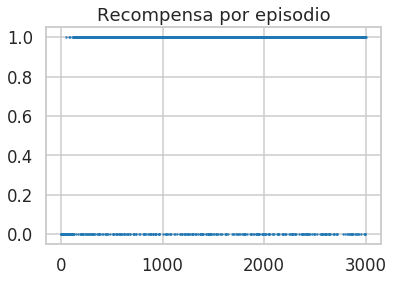

In [8]:
episode_rewards = np.array(agent.reward_of_episode)
plt.scatter(np.array(range(0, len(episode_rewards))), episode_rewards, s=0.7)
plt.title('Recompensa por episodio')
plt.show()

Veamos pasos por episodio

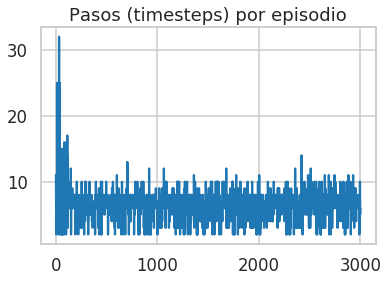

In [9]:
# se muestra la curva de aprendizaje de los pasos por episodio
episode_steps = np.array(agent.timesteps_of_episode)
plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
plt.title('Pasos (timesteps) por episodio')
plt.show()

Como vemos, los gráficos arrojan algo de información pero a su vez oscilan demasiado.  
Para contrarrestar esto procedemos a suavizarlos:

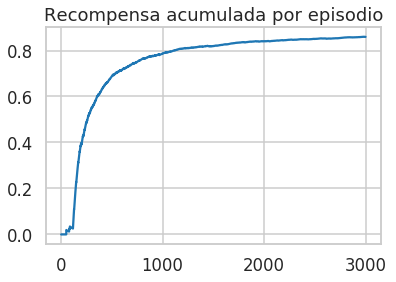

In [10]:
# se suaviza la curva de convergencia
episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
acumulated_rewards = np.cumsum(episode_rewards)

reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

plt.plot(reward_per_episode)
plt.title('Recompensa acumulada por episodio')
plt.show()

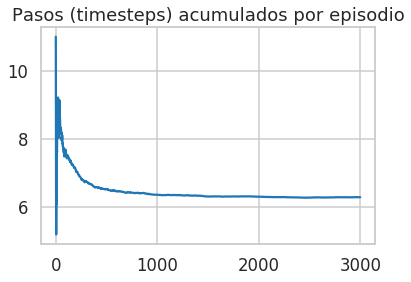

In [11]:
# se suaviza la curva de aprendizaje
episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
acumulated_steps = np.cumsum(episode_steps)

steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

plt.plot(steps_per_episode)
plt.title('Pasos (timesteps) acumulados por episodio')
plt.show()

#### **Análisis de matriz de valor y política óptima**

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor que alcanzó cada estado al finalizar la ejecución del agente y la acción que ejecutaría al llegar a cada estado\*.  
Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Teniendo los valores de $Q(s,a)$ para cada par estado-acción, el valor de cada estado se calcula a través de

$$V(s) = \sum_{a} \pi(a \mid s) Q(s, a) $$

donde $\pi(a \mid s)$ es la probabilidad de tomar la acción $a$ siendo que el agente se encuentra en el estado $s$.  
Siguiendo la política $\epsilon$-greedy, donde como ejemplo $\epsilon = 0.25$ y dado el conjunto de acciones posibles $A$ donde $\mid\;A\mid=4$, $\pi(a \mid s)$ está dado por:


$$
\pi(a \mid s) = \begin{cases}
                    0.75 + \frac{0.25}{4} & \text{si $a$ es la mejor acción}\\
                    \frac{0.25}{4} & \text{en caso contrario}
                \end{cases}
$$


Notar que la fracción $\frac{0.25}{4}$ se añade pues se tiene en cuenta que $a$ puede haber sido elegida aleatoriamente al ejecutar una acción exploratoria.  
Un criterio distinto podría ser que en la acción exploratoria se excluya a la mejor acción.


(\*) Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible.  
En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo.

Por otra parte, la acción óptima para cada estado se obtiene simplemente consultando el $Q(s,a)$ que mayor valor arroja. Gráficamente:

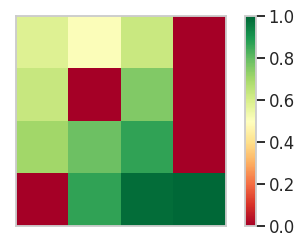


 Matriz de valor (en números): 

 [[0.58473272 0.51024546 0.63217969 0.        ]
 [0.63494077 0.         0.75642609 0.        ]
 [0.70548975 0.7859025  0.86895    0.        ]
 [0.         0.87096289 0.988      1.        ]]


In [12]:
# se procede con los cálculos previos a la graficación de la matriz de valor
value_matrix = np.zeros((4, 4))
for row in range(4):
    for column in range(4):

        state_values = []

        for action in range(4):
            state_values.append(agent.q.get((row * 4 + column, action), 0))
        
        maximum_value = max(state_values)  # como usamos epsilon-greedy, determinamos la acción que arroja máximo valor
        state_values.remove(maximum_value)  # removemos el ítem asociado con la acción de máximo valor
        
        # el valor de la matriz para la mejor acción es el máximo valor por la probabilidad de que el mismo sea elegido
        # (que es 1-epsilon por la probabilidad de explotación más 1/4 * epsilon por probabilidad de que sea elegido al
        # azar cuando se opta por una acción exploratoria)
        value_matrix[row, column] = maximum_value * (1 - epsilon + (1/4 * epsilon))
        
        for non_maximum_value in state_values:
            value_matrix[row, column] += (epsilon/4) * non_maximum_value
            
# el valor del estado objetivo se asigna en 1 (reward recibido al llegar) para que se coloree de forma apropiada
value_matrix[3, 3] = 1

# se grafica la matriz de valor
plt.imshow(value_matrix, cmap=plt.cm.RdYlGn)
plt.tight_layout()
plt.colorbar()

fmt = '.2f'
thresh = value_matrix.max() / 2.

plt.xticks([])
plt.yticks([])
plt.show()

print('\n Matriz de valor (en números): \n\n', value_matrix)

In [13]:
# destrucción del agente
agent.destroy_agent()

## Ejercicios Lab1

Para el presente lab vamos a utilizar la clase FrozenLakeAgent, llamada desde el presente notebook, y el script *frozenlake_main_script*, ubicado en *agents/frozen\_lake\_agent/*.  
Los mismos se presentan como herramientas para resolver los ejercicios, por lo que se permite, para la resolución de los mismos, modificarlos o reemplazarlos por sus propias implementaciones.  
Presentan la siguiente funcionalidad:

> frozenlake_main_script

Script que crea y define la configuración inicial del agente de RL de tipo FrozenLake, creando la instancia de FrozenLakeAgent.

> FrozenLakeAgent

Clase que implementa la interfaz con OpenAIGym, creando el entorno FrozenLake y aplicando acciones sobre el mismo.  
Adicionalmente provee una interfaz para llamar y correr el agente RL.

Adicionalmente, en la clase también se implementa el algoritmo QLearning, lo cual involucra el guardado de los valores de Q en un diccionario, la selección de acciones (mediante $choose\_action$) y la actualización de los valores de Q (mediante $learn$).

Se pide:

1. Dado el agente de Q-Learning en el entorno FrozenLake, implementar la política Softmax, dada por
$$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{a'}e^{Q(s,a')/\tau}}$$

2. Realizar una breve descripción analizando cómo difieren en la curva de aprendizaje los distintos valores de los híper-parámetros $\alpha$, $\epsilon$, $\tau$ y $\gamma$ tanto con política $\epsilon$-greedy como con Softmax.

3. Implementar algoritmo SARSA y compararlo con Q-Learning, en la curva de convergencia de la recompensa.  
Opcional: compararlos también en la matriz de valor, para lo cuál debe adaptarse la matriz de valor a la política Softmax (actualmente la misma está de acuerdo a la política epsilon-greedy).

4. Evaluar cómo cambia el desempeño de los algoritmos implementados con el entorno FrozenLake con Slippery = True.  
¿Cómo se comparan Q-Learning y SARSA? ¿Cómo es esta comparación de acuerdo a los valores de sus híper-parámetros?

5. Modificar la función de recompensa de modo tal que se penalice caer al agua o bien que se penalice cada time-step (o algún criterio similar).  
Analizar cómo difiere la convergencia en tales casos (comparando Q-Learning con SARSA).

6. Aumentar la cantidad de pasos posibles en el entorno (mediante el cutoff_time en el script y con max_episode_steps en la clase Q-Learning).  
Evaluar si la matriz de valor se ve afectada, y en tal caso describir cómo.

Para enviar el Lab, enviar la solución en un archivo comprimido a la dirección jbarsce | at | gmail | dot | com

**Nota 1**: puede utilizarse la versión más grande del FrozenLake, que es una grilla de tamaño 8x8 (solamente esta grilla o ambas grillas a modo de comparación).  
Para usarla, se debe modificar la variable en *register* del método *init_agent* de '4x4' a 8x8.

**Nota 2**: para visualizar los distintos aspectos del entorno frozen lake que se pueden cambiar en la función Register, seguir este link
https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

**Recomendación general**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo Pycharm, debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.